In [1]:
import torch
from torch import nn as nn
from torch.distributions import Normal, multivariate_normal
from torch.utils.data import Dataset, DataLoader
import numpy as np
import collections
from typing import Iterable
import scipy.sparse as sp_sparse
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from tqdm import trange
import sys
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import scanpy as sc
import torch.nn.functional as F

/ysm-gpfs/pi/zhao/Softwares/Anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
device = torch.device("cpu")

In [3]:
class Generate_X:
    def __init__(self, p, give_mean = 'zero', give_sigma = 'one'):
        """
        give_sigma: whether the Sigma is diagonal matrix and same across cell types.
                    'one': The variances of genes are all ones.
                    'linspace': The variances of genes are different but even spaced numbers
                    'uniform': The variances of gene are randomly generated from [0,1]
        """
        self.p = p
        if give_mean is 'zero':
            self.mean = np.array([0]*self.p, dtype =float)
        elif give_mean is 'linspace':
            self.mean = np.linspace(0,2,num = self.p, dtype=float)
        elif give_mean is 'uniform':
            self.mean =  np.random.rand(self.p, dtype = float)
        else:
            print('Wrong argument!')
            pass
        if give_sigma is 'one':
            self.sigma = np.array([1]*self.p)
        elif give_sigma is 'linspace':
            self.sigma = np.linspace(0,2,num = self.p)
        elif give_mean is 'uniform':
            self.sigma =  np.random.rand(self.p)
        else:
            print('Wrong argument!')
            pass
        

    def sym_Sigma(self):
        p = self.p
        L = np.tril(np.random.random((p,p))*2,0)
        sparse = np.random.binomial(1,0.2,(p,p))
        diag_indices = np.diag_indices(p)
        sparse[diag_indices] = 1
        L = L * sparse
        S = np.matmul(L,L.transpose())
        return S

    def generate(self, n_ct, n_vec, same_mean = True, same_sigma = True):
        """
        n_ct: int, the number of cell types
        n_vec: the vector of cell size
        """
        assert n_ct == len(n_vec)
        ct_label = []
        rst = []
        covmat = []
        meanmat = []
        for ct in range(n_ct):  # ct: cell type
            if same_sigma:
                Sigma = np.diag(self.sigma)
            else:
                Sigma = self.sym_Sigma()
            Sigma = Sigma.astype(float)
            if same_mean:
                mean = self.mean
            else:
                mean = (np.random.rand(self.p)-0.5)*10
            MVN = np.random.multivariate_normal(mean, Sigma, n_vec[ct])
            #print(MVN)
            rst.append(MVN)
            ct_label.append(np.array([ct]*n_vec[ct]))
            covmat.append(Sigma)
            meanmat.append(mean)
        mat = np.array(rst)
        ct_label = np.array(ct_label)
        self.X = np.reshape(mat, (-1,self.p))
        self.ct_label = np.reshape(ct_label, (-1,))
        self.covmat = covmat
        self.meanmat = meanmat
        # print(self.X, self.ct_label)

In [4]:
def sim_sample_indices(sample_size):
    sample_indices = [[i]*sample_size[i] for i in range(len(sample_size))]
    return np.asarray(sample_indices).flatten()


In [5]:
class CytofDataset_Sim(Dataset):
    """ Create CyTOF dataset for Pytorch in Simulation
        The class contains __len__() and __getitem__() which could be used for dataloader.
    
    """

    def __init__(self,X, sample_indices, label_indices):
        self.dense = type(X) is np.ndarray
        self._X = np.ascontiguousarray(X, dtype=np.float32) if self.dense else X
        self.nb_genes = self.X.shape[1]
        self.samples, self.n_samples, self.sample_dict = arrange_categories(sample_indices)
        self.labels, self.n_labels, self.label_dict = arrange_categories(label_indices)

    @property
    def X(self):
        return self._X

    def __len__(self):
        return self._X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.samples[idx], self.labels[idx]
    
#    def collate_fn(self, batch):
#        indexes = np.array(batch)
#        X = self.X[indexes]
#        return self.collate_fn_end(X, indexes)
#    
#    def collate_fn_end(self, X, indexes):

#        if self.dense:
#            X = torch.from_numpy(X)
#        else:
#            X = torch.FloatTensor(X.toarray())
#        return X,  torch.LongTensor(self.samples[indexes]), \
#                   torch.LongTensor(self.labels[indexes])


    def get_sample(self, sample_sublist):
        """
        sample_sublist: list
        """
        loc = np.array([np.where(self.samples == self.sample_dict[sample]) for sample in sample_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub
    
    def get_celltype(self, celltype_sublist):
        """
        celltype_sublist: list
        """
        loc = np.array([np.where(self.labels == self.label_dict[batch]) for label in celltype_sublist]).flatten()
        X_sub = self._X[loc]
        samples_sub = self.samples[loc]
        labels_sub = self.labels[loc]
        return X_sub, samples_sub, labels_sub

In [13]:
def arrange_categories(original_categories, mapping_from=None, mapping_to=None):
    unique_categories = np.unique(original_categories)
    n_categories = len(unique_categories)
    batch_dict = dict()
    if mapping_to is None:
        mapping_to = range(n_categories)
    if mapping_from is None:
        mapping_from = unique_categories
    assert n_categories <= len(mapping_from)  # one cell_type can have no instance in dataset # Haven't debug it. Assume we have more than one cell type.
    assert len(mapping_to) == len(mapping_from)

    new_categories = np.copy(original_categories)
    for idx_from, idx_to in zip(mapping_from, mapping_to):
        # print(idx_from, idx_to)
        new_categories[original_categories == idx_from] = idx_to
        batch_dict[idx_from] = idx_to
    return new_categories.astype(int), n_categories, batch_dict


In [6]:
class Manual_Layers(nn.Module):
    def __init__(self, n_in=10, n_hidden=100, n_out=2):
        super(Manual_Layers, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.LeakyReLU(0.2),
            nn.Linear(n_hidden, n_out*2),
        )
        
        
    def forward(self, x: torch.Tensor):
        x = self.layers(x)
        
        return x

In [7]:
class Encoder(nn.Module):
    r"""Encodes data of ``n_input`` dimensions into a latent space of ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (data space)
    :param n_output: The dimensionality of the output (latent space)
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    :dropout_rate: Dropout rate to apply to each of the hidden layers
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128, dropout_rate: float = 0.1):
        super(Encoder, self).__init__()

        #self.encoder = FCLayers(n_in=n_input, n_out=n_hidden, n_layers=n_layers,
        #                        n_hidden=n_hidden, dropout_rate=dropout_rate)
        #self.mean_encoder = nn.Linear(n_hidden, n_output)
        #self.var_encoder = nn.Linear(n_hidden, n_output)
            
        self.encoder = Manual_Layers(n_in = n_input, n_hidden = n_hidden, n_out = n_output)
       

    def reparameterize(self, mu, var):
        return Normal(mu, var.sqrt()).rsample()
    
    def encoder_function(self, x):
        h = self.encoder(x)
        q_m, q_logv = torch.chunk(h, 2, dim=1)
        return q_m, q_logv

    def forward(self, x: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Encodes the data into latent space using the encoder network
         #. Generates a mean \\( q_m \\) and variance \\( q_v \\) (clamped to \\( [-5, 5] \\))
         #. Samples a new value from an i.i.d. multivariate normal \\( \\sim N(q_m, \\mathbf{I}q_v) \\)

        :param x: tensor with shape (n_input,)
        :return: tensors of shape ``(n_latent,)`` for mean and var, and sample
        :rtype: 3-tuple of :py:class:`torch.Tensor`
        """

        # Parameters for latent distribution
        q_m, q_logv = self.encoder_function(x)
        q_v = torch.exp(q_logv)
        
        #q = self.encoder(x)
        #q_m = self.mean_encoder(q)
        #q_v = torch.exp(self.var_encoder(q))  # (computational stability safeguard)torch.clamp(, -5, 5)
        latent = self.reparameterize(q_m, q_v)
        return q_m, q_v, latent

In [8]:
class DecoderVCSC(nn.Module):
    r"""Decodes data from latent space of ``n_input`` dimensions ``n_output``
    dimensions using a fully-connected neural network of ``n_hidden`` layers.

    :param n_input: The dimensionality of the input (latent space)
    :param n_output: The dimensionality of the output (data space). It is also the number of genes
    :param n_cat_list: A list containing the number of categories
    :param n_layers: The number of fully-connected hidden layers
    :param n_hidden: The number of nodes per hidden layer
    """

    def __init__(self, n_input: int, n_output: int,
                 n_layers: int = 1,
                 n_hidden: int = 128):
        super(DecoderVCSC, self).__init__()

        # shape: shape parameter in gamma distribution infered from estimated covariance matrix
        self.px_decoder =Manual_Layers(n_in = n_input, n_hidden = n_hidden, n_out = n_output)
        
        # mu
        self.px_mu_decoder =  nn.Linear(n_hidden, n_output)

#         # D
#         self.px_D_decoder = nn.Sequential(nn.Linear(n_hidden, n_output))

#         # L
#         self.px_L_decoder = nn.Linear(n_hidden, int(n_output*(n_output-1)/2))

#         # dropout
#         #self.px_dropout_decoder = nn.Linear(n_hidden, n_output)




    def forward(self, z: torch.Tensor):
        r"""The forward computation for a single sample.

         #. Decodes the data from the latent space using the decoder network
         #. Returns parameters for the multiVariate normal distribution of expression

        :param z: tensor with shape ``(n_input,)``
        :param mu: empirical mean parameter in multivariate normal distribution with shape ``(#gene,)``
        :param D: diagonal vector of D in cholesky decomposition, where \Sigma = L^T * D * L, 
                    and \Sigma is cov matrix in multivariate normal distribution with shape ``(#gene,)``
        :param L: vector of unit lower triangular L matrix in cholesky decomposition with shape ``(#gene*(#gene-1)/2)``
        :return: parameters for the multivariate normal distribution of expression
        :rtype: `torch.Tensor`
        """

        

        # The decoder returns values for the parameters of the ZINB distribution
        px = self.px_decoder(z)
        px_mu = self.px_mu_decoder(px)
#         px_D = self.px_D_decoder(px)
#         px_D = torch.exp(px_D)
#         px_L = self.px_L_decoder(px)
        #print(px_L.size())
        #px_L = self.ReshapeL(px_L)
        #px_L = self.ReshapeL(px_L)
        #px_dropout = self.px_dropout_decoder(px_sigma)
        
        
#         return px_mu, px_D, px_L
        return px_mu

In [42]:
def log_gaussian_positive(x, px_mu):
    """
    This log likelihood is replaced by L2 square error
    """

    reconst_loss =  -((px_mu-x)**2).sum(dim=-1) 

    
    #res = part1 + part2
    return reconst_loss

In [81]:
class VAE(nn.Module):
    r"""Variational auto-encoder model.

    :param n_input: Number of input genes
    :param n_batch: Number of batches
    :param n_labels: Number of labels
    :param n_hidden: Number of nodes per hidden layer
    :param n_latent: Dimensionality of the latent space
    :param n_layers: Number of hidden layers used for encoder and decoder NNs
    :param dropout_rate: Dropout rate for neural networks
    """

    def __init__(self, n_input: int, n_labels: int = 18,
                 n_hidden: int = 128, n_latent: int = 10, n_layers: int = 1,
                 dropout_rate: float = 0.1):
        super(VAE, self).__init__()
        self.n_latent = n_latent
        self.n_labels = n_labels

        self.z_encoder = Encoder(n_input, n_latent, n_layers=n_layers, n_hidden=n_hidden,
                                 dropout_rate=dropout_rate)
        # decoder goes from n_latent-dimensional space to n_input-d data
        self.decoder = nn.Linear(n_latent, n_input)
        # self.decoder = DecoderVCSC(n_latent, n_input, n_layers=n_layers, n_hidden=n_hidden)

    def get_latents(self, x, give_mean):
        r""" returns the result of ``sample_from_posterior_z`` inside a list

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: one element list of tensor
        :rtype: list of :py:class:`torch.Tensor`
        """
        return [self.sample_from_posterior_z(x, give_mean)]

    def sample_from_posterior_z(self, x, give_mean=False):
        r""" samples the tensor of latent values from the posterior
        #doesn't really sample, returns the means of the posterior distribution

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :param give_mean: is True when we want the mean of the posterior  distribution rather than sampling
        :return: tensor of shape ``(batch_size, n_latent)``
        :rtype: :py:class:`torch.Tensor`
        """
        qz_m, qz_v, z = self.z_encoder(x)  
        if give_mean:
            z = qz_m
        return z

    def get_sample_mu(self, x):
        r"""Returns the tensor of predicted frequencies of expression

        :param x: tensor of values with shape ``(batch_size, n_input)``
        :return: tensor of predicted frequencies of expression with shape ``(batch_size, n_input)``
        """
        return self.inference(x)[0]

    # def get_sample_D(self, x):
    #     r"""Returns the tensor of means of the negative binomial distribution

    #     :param x: tensor of values with shape ``(batch_size, n_input)``
    #     :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
    #     """
    #     return self.inference(x)[1]

    # def get_sample_L(self, x):
    #     r"""Returns the tensor of means of the negative binomial distribution

    #     :param x: tensor of values with shape ``(batch_size, n_input)``
    #     :return: tensor of means of the negative binomial distribution with shape ``(batch_size, n_input)``
    #     """
    #     return self.inference(x)[2]

    def _reconstruction_loss(self, x, px_mu):
        # Reconstruction Loss
        #reconst_loss = -log_gaussian_positive(x, px_mu, px_D, px_L)
        #return reconst_loss
        
        recon_loss = log_gaussian_positive(x, px_mu)
        return - recon_loss
    

    def inference(self, x):
        x_ = x

        # Sampling
        qz_m, qz_v, z = self.z_encoder(x_)

        # px_mu, px_D, px_L = self.decoder(z)
        px_mu = self.decoder(z)
        

        return px_mu, qz_m, qz_v, z
    
    # def reconst_x(self, px_mu, px_D):
    #     reconst_x = Normal(px_mu, 1/px_D).rsample()
        

    def forward(self, x):
        r""" Returns the reconstruction loss and the Kullback divergences

        :param x: tensor of values with shape (batch_size, n_input)
        :return: the reconstruction loss and the Kullback divergences
        """
        # Parameters for z latent distribution

        px_mu, qz_m, qz_v, z = self.inference(x)
        #reconst_loss = self._reconstruction_loss(x, px_mu, px_D, px_L)
        reconst_loss = self._reconstruction_loss(x, px_mu)

        # KL Divergence between two multivariate normal distributions
        # mean = torch.zeros_like(qz_m)
        # scale = torch.ones_like(qz_v)

        # kl_divergence = torch.distributions.kl.kl_divergence(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean, scale)).sum(dim=-1)
        kl_divergence = - 0.5 * torch.sum(1 + torch.log(qz_v) - qz_m**2 - qz_v)
        
        return reconst_loss, kl_divergence

In [11]:
# Generate Simulation dataset in 10 dimensional space and 2 cell types. There are 1500 cells in each cell type population. No multi-sample problem included.
sim1 = Generate_X(10)
sim1.generate(2,[1500,1500], same_mean = False, same_sigma = False)
sample_size = np.repeat(3000,1)
sample_indices = sim_sample_indices(sample_size)

In [14]:
# Generate CytofDataset_Sim class
simX_data = CytofDataset_Sim(sim1.X, sample_indices, sim1.ct_label)
simX, _, labels = simX_data.get_sample([0]) ## Used for simulation without multiple batches integration
gene_dataset = simX_data

In [15]:
# Parameters Setup
p = 10 # dimension of X
d = 2 # dimension of z
n_input = p
n_latent = d
n_layers = 3
n_hidden = 20 # dimension of hidden layer
dropout_rate = 0.1
n_epochs = 150
lr=1e-3
batch_size = 1500

In [17]:
np.savetxt('./write/simulation', sim1.X, delimiter = ',')
adata = sc.read_csv('./write/simulation')
adata.obs['cell type'] = sim1.ct_label
adata.obs['batch'] = sample_indices

In [18]:
sc.pp.neighbors(adata, n_neighbors = 15, metric = 'euclidean', random_state = None)
sc.tl.umap(adata, min_dist = 0.1)


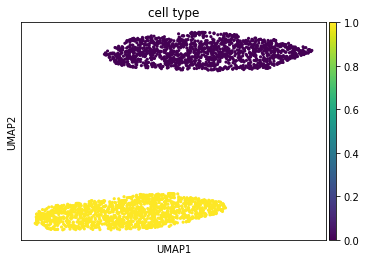

In [19]:
sc.pl.umap(adata, color = 'cell type')

In [104]:
vae = VAE(gene_dataset.nb_genes, gene_dataset.n_labels,
                 n_hidden = n_hidden, n_latent = n_latent, n_layers = n_layers)

In [105]:
mu_init = vae.get_sample_mu(torch.from_numpy(gene_dataset.X))

In [106]:
epochs = 100
data_loader =  torch.utils.data.DataLoader(gene_dataset, batch_size = 100, shuffle =True)

In [107]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [108]:
for epoch in range(epochs):
    KL_weight = min(0.1, epoch/400)
    for tensors_list in data_loader:
        X, sample_list, label_list = tensors_list
        recon_loss, KL = vae(X)
        loss = torch.mean(recon_loss + KL_weight* KL)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data/batch_size))

Epoch[1/100] Loss: 0.075
Epoch[2/100] Loss: 0.072
Epoch[3/100] Loss: 0.065
Epoch[4/100] Loss: 0.063
Epoch[5/100] Loss: 0.063
Epoch[6/100] Loss: 0.063
Epoch[7/100] Loss: 0.056
Epoch[8/100] Loss: 0.052
Epoch[9/100] Loss: 0.050
Epoch[10/100] Loss: 0.048
Epoch[11/100] Loss: 0.047
Epoch[12/100] Loss: 0.047
Epoch[13/100] Loss: 0.045
Epoch[14/100] Loss: 0.046
Epoch[15/100] Loss: 0.042
Epoch[16/100] Loss: 0.044
Epoch[17/100] Loss: 0.039
Epoch[18/100] Loss: 0.043
Epoch[19/100] Loss: 0.041
Epoch[20/100] Loss: 0.041
Epoch[21/100] Loss: 0.040
Epoch[22/100] Loss: 0.039
Epoch[23/100] Loss: 0.040
Epoch[24/100] Loss: 0.038
Epoch[25/100] Loss: 0.040
Epoch[26/100] Loss: 0.044
Epoch[27/100] Loss: 0.039
Epoch[28/100] Loss: 0.039
Epoch[29/100] Loss: 0.040
Epoch[30/100] Loss: 0.040
Epoch[31/100] Loss: 0.038
Epoch[32/100] Loss: 0.040
Epoch[33/100] Loss: 0.042
Epoch[34/100] Loss: 0.038
Epoch[35/100] Loss: 0.040
Epoch[36/100] Loss: 0.039
Epoch[37/100] Loss: 0.040
Epoch[38/100] Loss: 0.037
Epoch[39/100] Loss: 0

In [109]:
mu_out = vae.get_sample_mu(torch.from_numpy(gene_dataset.X))

In [110]:
x = gene_dataset.X
x = torch.from_numpy(x).float()
z = vae.get_latents(x, give_mean=True)
z = z[0].detach().numpy()

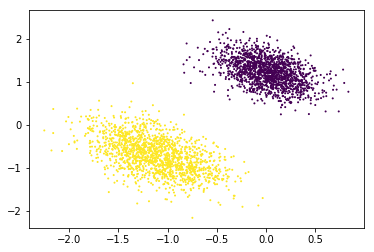

In [111]:
plt.scatter(z[:,0], z[:,1], c = gene_dataset.labels, s = [1]*len(z), marker='o')

([array([  3.,  27., 178., 568., 544., 166.,  13.,   1.,   0.,   0.]),
  array([  0.,   0.,   5.,  46., 308., 600., 424., 105.,  11.,   1.]),
  array([  7.,  40., 193., 333., 410., 340., 137.,  33.,   7.,   0.]),
  array([  0.,   0.,   1.,  22., 145., 393., 517., 342.,  71.,   9.])],
 array([-1.8428144 , -0.853525  ,  0.13576451,  1.125054  ,  2.1143434 ,
         3.103633  ,  4.092922  ,  5.082212  ,  6.0715013 ,  7.060791  ,
         8.05008   ], dtype=float32),
 <a list of 4 Lists of Patches objects>)

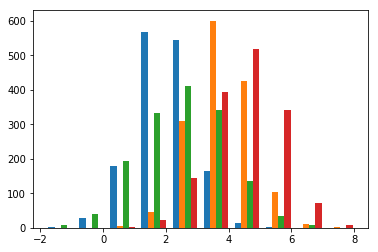

In [124]:
# Comparing true mean and estimated means
i= 7
plt.hist([mu_out[0:1500,i].detach().numpy(),mu_out[1500:3000,i].detach().numpy(), gene_dataset.X[0:1500,i], gene_dataset.X[1500:3000,i]], label = ["ct_1_out","ct_2_out", "ct_1", "ct_2"])


In [59]:
mu_out

tensor([[-4.1520, -0.3836,  0.3578,  ...,  3.5136,  1.3413, -3.4974],
        [-3.9964, -0.3718,  0.3312,  ...,  3.4554,  1.2794, -3.4222],
        [-4.0183, -0.3721,  0.3074,  ...,  3.4765,  1.3369, -3.4283],
        ...,
        [-4.0992, -0.3481,  0.3595,  ...,  3.4876,  1.3897, -3.4629],
        [-4.1139, -0.3899,  0.3628,  ...,  3.4985,  1.2865, -3.4819],
        [-4.0081, -0.3699,  0.3128,  ...,  3.4806,  1.3117, -3.4390]],
       grad_fn=<AddmmBackward>)